# **ITEM DEMAND FORECASTING**






**Time-series**

    A time-series data is a series of data points or observations recorded at different or regular time intervals. 
    In general, a time series is a sequence of data points taken at equally spaced time intervals. 
    The frequency of recorded data points may be hourly, daily, weekly, monthly, quarterly or annually.

**Time-Series Forecasting**

    Time-Series Forecasting is the process of using a statistical model to predict future values of a time-series based on past results.

**LIGHTBGM**

    Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree 
    algorithm, used for ranking, classification and many other machine learning tasks.

In [ ]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import time
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
from matplotlib.dates import date2num

from sklearn.model_selection import RandomizedSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error,r2_score

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
warnings.filterwarnings('ignore')

In [ ]:
#Importing train data in a time series dataframe format

df= pd.read_csv(r'C:\IITM_project\train2.csv',parse_dates=['date'])

# EDA
Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

In [ ]:
# Printing the shape of the DataFrame
print(f'Dataframe Shape : {df.shape}')

Dataframe Shape : (913000, 4)


In [ ]:
# Checking the data types of the dataframe
print(f'Data Types of the DataFrame : {df.dtypes}')

Data Types of the DataFrame : date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object


In [ ]:
# Checking is there is any null values in the DataFrame
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [ ]:
# Checking the Quantiles of the DataFrame
print(df.describe(percentiles=[0, 0.05, 0.50, 0.75, 0.95, 0.99]).T)

          count       mean        std  min   0%    5%   50%   75%    95%  \
store  913000.0   5.500000   2.872283  1.0  1.0   1.0   5.5   8.0   10.0   
item   913000.0  25.500000  14.430878  1.0  1.0   3.0  25.5  38.0   48.0   
sales  913000.0  52.250287  28.801144  0.0  0.0  16.0  47.0  70.0  107.0   

         99%    max  
store   10.0   10.0  
item    50.0   50.0  
sales  135.0  231.0  


In [ ]:
# checking the unique values of the item feature
df['item'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
      dtype=int64)

In [ ]:
# Printing the maximum of the date
df['date'].max()

Timestamp('2017-12-31 00:00:00')

In [ ]:
# Printing the minimum of the date
df['date'].min()

Timestamp('2013-01-01 00:00:00')

In [ ]:
# Which is the highest sale value among all sales?
df[df["sales"] == df["sales"].max()]

,date,store,item,sales
259109,2017-07-02,2,15,231


In [ ]:
# Which is the lowest sale value among all sales?
df[df["sales"] == df["sales"].min()]

,date,store,item,sales
64289,2014-01-15,6,4,0


In [ ]:
# checking theunique values of the store features
df['store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [ ]:
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [ ]:
# Are there same nbr of items in each store?
df.groupby('store').agg({'item':'nunique'})

,item
store,
1,50
2,50
3,50
4,50
5,50
6,50
7,50
8,50
9,50


In [ ]:
# Are there same nbr of sales in each store?
df.groupby(['store','item']).agg({'sales':'sum'})

sales
store item        
1     1      36468
      2      97050
      3      60638
      4      36440
      5      30335
...            ...
10    46    120601
      47     45204
      48    105570
      49     60317
      50    135192

[500 rows x 1 columns]

In [ ]:
# What are the descriptive statistics with store and item breakdown?
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
               sum       mean median        std
store item                                     
1     1      36468  19.971522   19.0   6.741022
      2      97050  53.148959   52.0  15.005779
      3      60638  33.208105   33.0  10.072529
      4      36440  19.956188   20.0   6.640618
      5      30335  16.612815   16.0   5.672102
...            ...        ...    ...        ...
10    46    120601  66.046550   65.0  18.114991
      47     45204  24.755750   24.0   7.924820
      48    105570  57.814896   57.0  15.898538
      49     60317  33.032311   32.0  10.091610
      50    135192  74.037240   73.0  19.937566

[500 rows x 4 columns]

In [ ]:
# which PERIOD OF TIME (day, week, month...) was the most profitable (considering all product and item sales)?

def profit(period="D", plot=False):

    df_profit = df.copy()
    df_profit.set_index("date", inplace=True)
    df_profit = df_profit.resample(period, closed='right').sum()
    df_profit.drop(columns=["store", "item"], inplace=True)
    df_profit["growth_rate"] = df_profit["sales"].pct_change() * 100
    df_profit.loc[[df_profit.index.min(), df_profit.index.max()], 'growth_rate'] = 0
    print(df_profit["sales"][df_profit["sales"] == df_profit["sales"].max()])

    if plot:
        df_profit["growth_rate"].plot(color="g", figsize=(8,5))
        plt.title(f"{period}'s growth rate")
        plt.xlabel("Date")
        plt.ylabel("Growth Rate %")
        plt.show()

    return df_profit

date
2017-07-31    1171393
Freq: M, Name: sales, dtype: int64


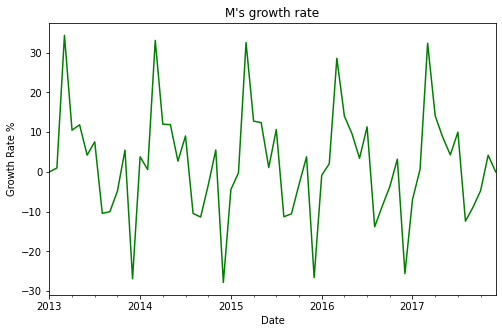

In [ ]:
#checking for monthly profit sales
df_month = profit("M", True)

date
2017-09-30    3133059
Freq: Q-DEC, Name: sales, dtype: int64


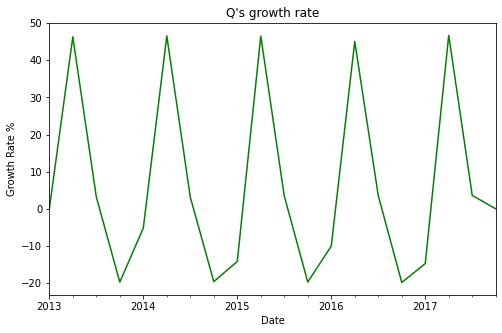

In [ ]:
#checking for quarterly profit sales
df_quater = profit("Q", True)

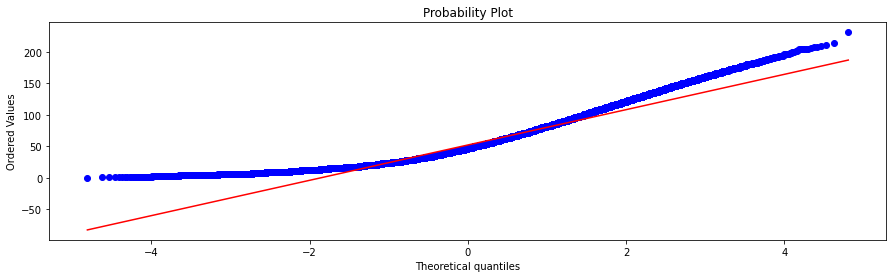

In [ ]:
# Checking the Distribution of the Sales Feature
import scipy.stats as stat
import pylab 

def plot_data(df,feature):
  plt.figure(figsize=(15,4))
  plt.subplot(1,1,1)
  stat.probplot(df[feature],dist='norm',plot=pylab)
  plt.show()

plot_data(df,'sales')

# FEATURE ENGG
As we'll be using time series's features for machine learning, we'll should be generating new features to rise machine's success.

In the very first step, we'll be generating features based on datetime variable. This will help us find the seasonality in time series.

In [ ]:
df.head()
df1=df.copy()

In [ ]:
# Generating new columns for model development
def create_date_features(df):
    df['month'] = df.date.dt.month   
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    df['quarter'] = df['date'].dt.quarter
  
    return df

In [ ]:
df_new = create_date_features(df1)


In [ ]:
df_new.head()

,date,store,item,sales,month,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter
0,2013-01-01,1,1,13,1,1,1,2013,0,1,0,1
1,2013-01-02,1,1,11,1,1,2,2013,0,0,0,1
2,2013-01-03,1,1,14,1,1,3,2013,0,0,0,1
3,2013-01-04,1,1,13,1,1,4,2013,1,0,0,1
4,2013-01-05,1,1,10,1,1,5,2013,1,0,0,1


In [ ]:
df_new.groupby(["store", "item","month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                    sum       mean median        std
store item month                                    
1     1    1       2125  13.709677   13.0   4.397413
           2       2063  14.631206   14.0   4.668146
           3       2728  17.600000   17.0   4.545013
           4       3118  20.786667   20.0   4.894301
           5       3448  22.245161   22.0   6.564705
...                 ...        ...    ...        ...
10    50   8      13108  84.567742   85.0  15.676527
           9      11831  78.873333   79.0  15.207423
           10     11322  73.045161   72.0  14.209171
           11     11549  76.993333   77.0  16.253651
           12      8724  56.283871   56.0  11.782529

[6000 rows x 4 columns]

[Text(0.5, 1.0, 'MONTH vs SALES')]

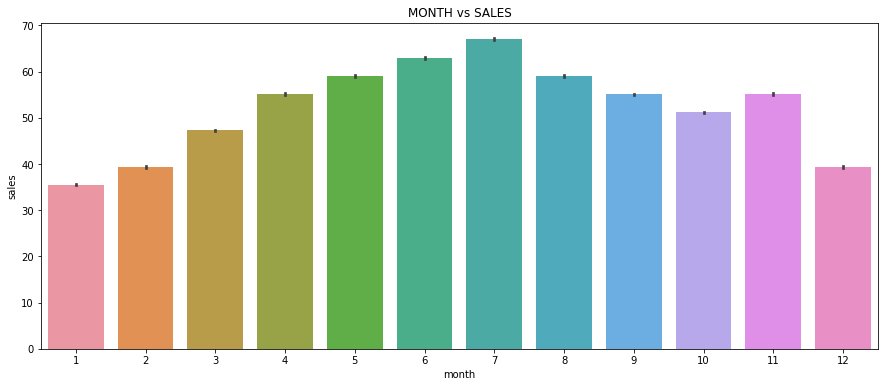

In [ ]:
# plotting the Month vs Sales
plt.figure(figsize=(15, 6))
sns.barplot(data=df_new, x="month", y="sales").set(title='MONTH vs SALES')

[Text(0.5, 1.0, 'YEAR vs SALES')]

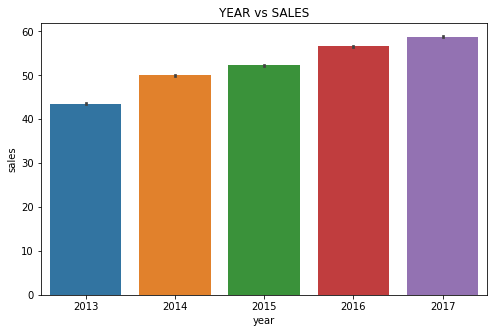

In [ ]:
# plotting the Year vs Sales
plt.figure(figsize=(8, 5))
sns.barplot(data=df_new, x="year", y="sales").set(title='YEAR vs SALES')

[Text(0.5, 1.0, 'QUARTER vs SALES')]

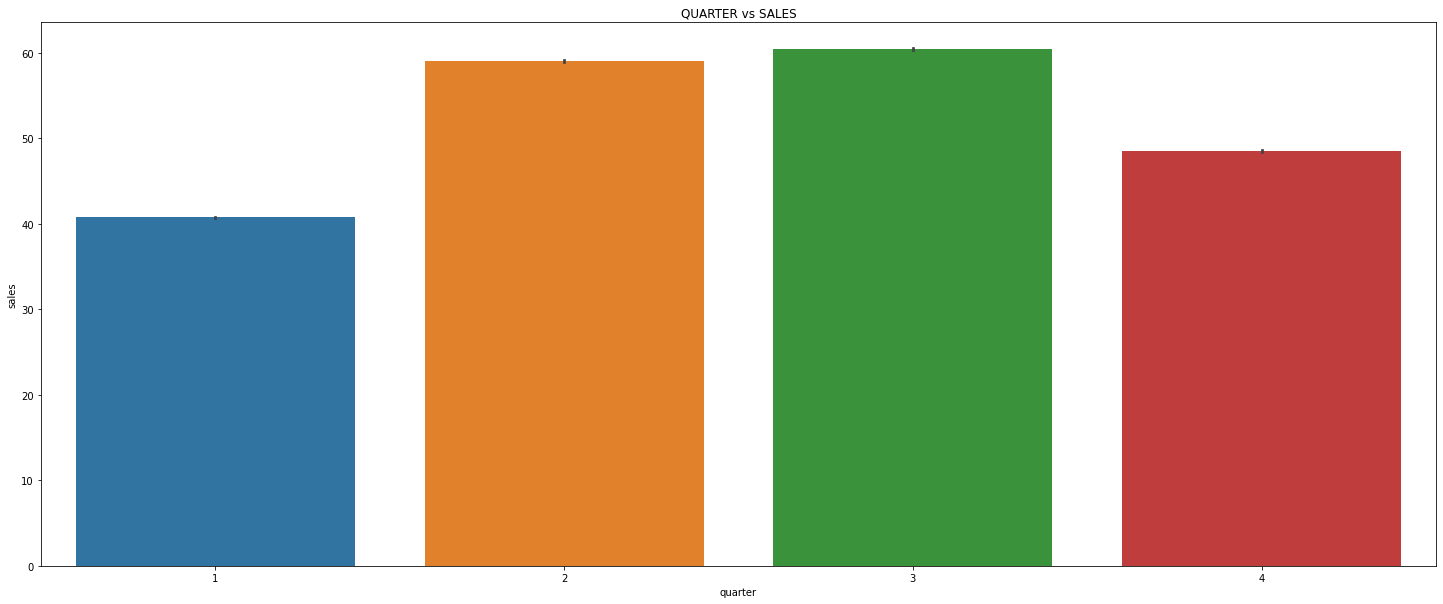

In [ ]:
# plotting the Quarter vs Sales
sns.barplot(data=df_new, x='quarter', y='sales').set(title='QUARTER vs SALES')

[Text(0.5, 1.0, 'WEEKEND vs SALES')]

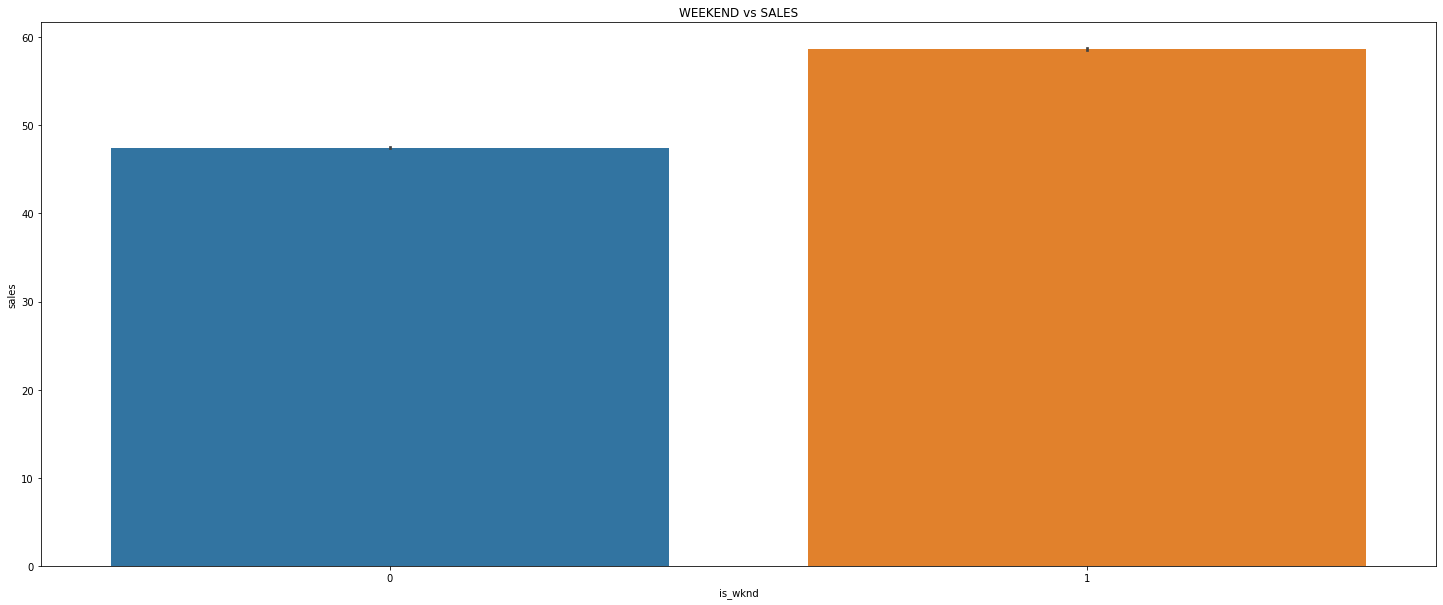

In [ ]:
# plotting the is_wknd vs sales
sns.barplot(data=df_new, x="is_wknd", y="sales").set(title='WEEKEND vs SALES')

[Text(0.5, 1.0, 'ITEMS vs SALES')]

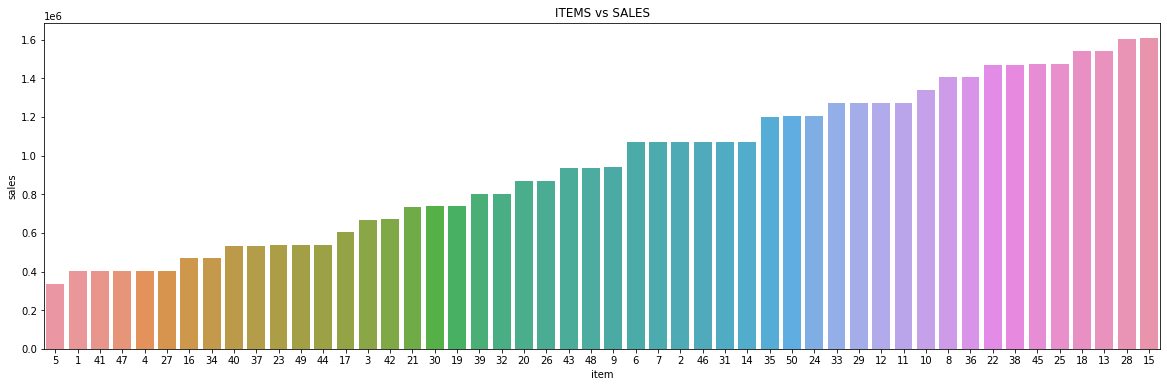

In [ ]:
# aggregating the items and printing the sales sum on ascending order
items = df_new.groupby(["item"]).agg({  "sales"   : "sum"}).reset_index().sort_values(by='sales',ascending=True)
 
# plotting the item vs sales
fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(data=items, x="item", y="sales", order=items.sort_values('sales', ascending=True).item).set(title='ITEMS vs SALES')

[Text(0.5, 1.0, 'Monthly sales')]

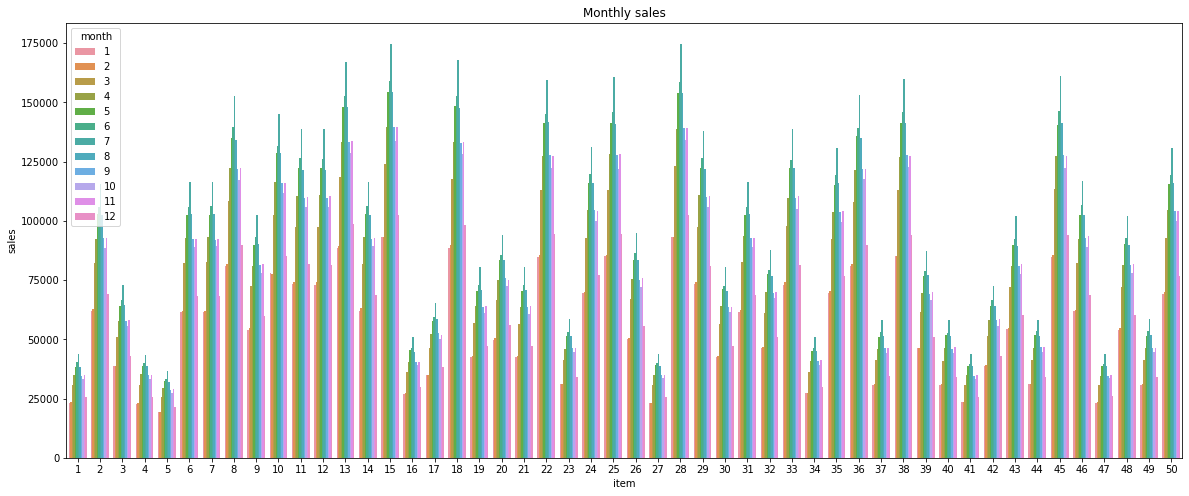

In [ ]:
month_item = df_new.groupby(['month','item']).agg({  "sales"   : "sum"}).reset_index()

# ploting the quarterly wise each item sales 
plt.figure(figsize=(20, 8))
sns.barplot(data = month_item,x = 'item' ,y = 'sales', hue = 'month').set(title='Monthly sales')

[Text(0.5, 1.0, 'Quarterly sales')]

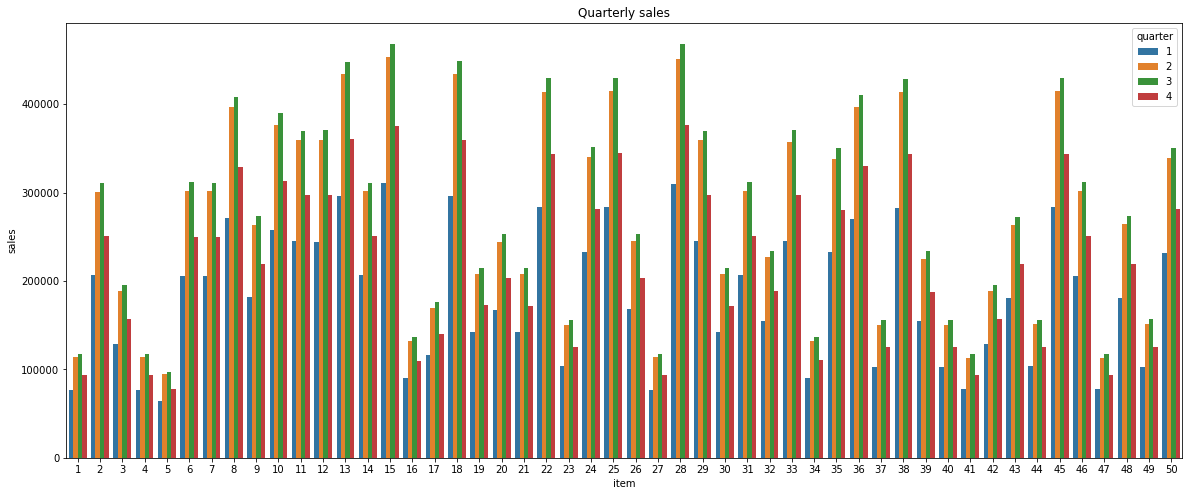

In [ ]:
quarter_item = df_new.groupby(['quarter','item']).agg({  "sales"   : "sum"}).reset_index()

# ploting the quarterly wise each item sales 
plt.figure(figsize=(20, 8))
sns.barplot(data = quarter_item,x = 'item' ,y = 'sales', hue = 'quarter').set(title='Quarterly sales')

[Text(0.5, 1.0, 'Yearly sales')]

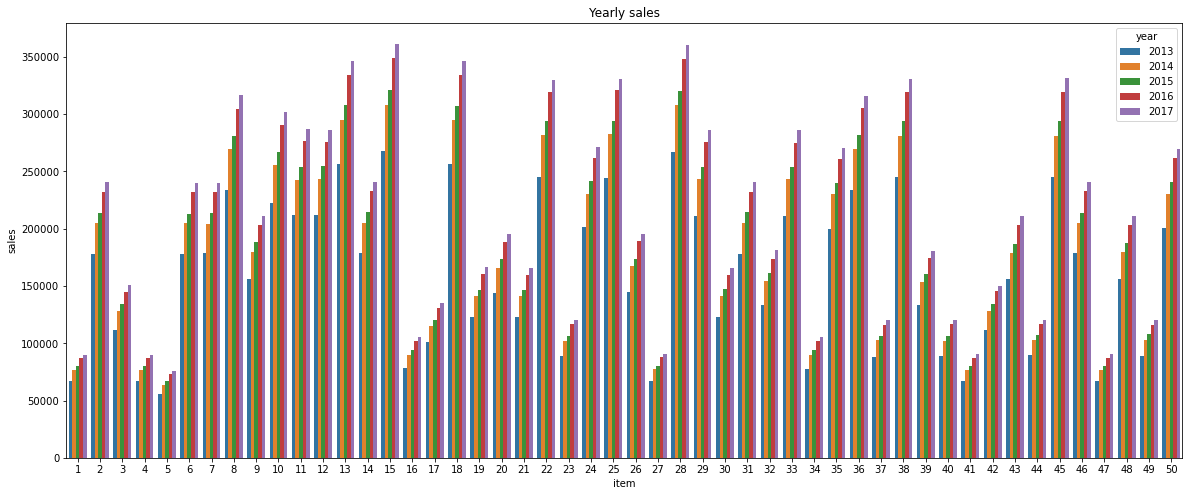

In [ ]:
year_item = df_new.groupby(['year','item']).agg({  "sales"   : "sum"}).reset_index()

# ploting the quarterly wise each item sales 
plt.figure(figsize=(20, 8))
sns.barplot(data = year_item,x = 'item' ,y = 'sales', hue = 'year').set(title='Yearly sales')

In [ ]:
# creating the new groupby dataframe series by grouping the item by date wise and aggregating sum of the sales
monthly_data = df_new.groupby(['item','date'])['sales'].sum()
monthly_data

item  date      
1     2013-01-01    133
      2013-01-02     99
      2013-01-03    127
      2013-01-04    145
      2013-01-05    149
                   ... 
50    2017-12-27    511
      2017-12-28    587
      2017-12-29    596
      2017-12-30    612
      2017-12-31    626
Name: sales, Length: 91300, dtype: int64

In [ ]:
# calculating the sum of sales for each item in 3 month level
quarterly_sales = []
for item in range(1,51):
  ts = pd.Timestamp('2013-01-01')
  while(ts <= pd.Timestamp("2017-10-03")):
    d4 = dict()
    d4['item'] = item
    d4['date'] = ts
    d4['quarterly_sales'] = monthly_data.loc[item, ts:ts+pd.DateOffset(days = 90)].sum()
    quarterly_sales.append(d4)
    ts +=pd.DateOffset(days = 7)

In [ ]:
# creating a dataframe and adding generated values 
df_quart = pd.DataFrame(quarterly_sales)
df_quart.head()

,item,date,quarterly_sales
0,1,2013-01-01,12981
1,1,2013-01-08,13542
2,1,2013-01-15,14030
3,1,2013-01-22,14500
4,1,2013-01-29,15003


In [ ]:
df_quart['year'] = df_quart['date'].dt.year # year column

df_quart['day'] = df_quart['date'].dt.day # day of the month  column

df_quart['quarter'] = df_quart['date'].dt.quarter # quarter of the year column

df_quart['month'] = df_quart['date'].dt.month # month column

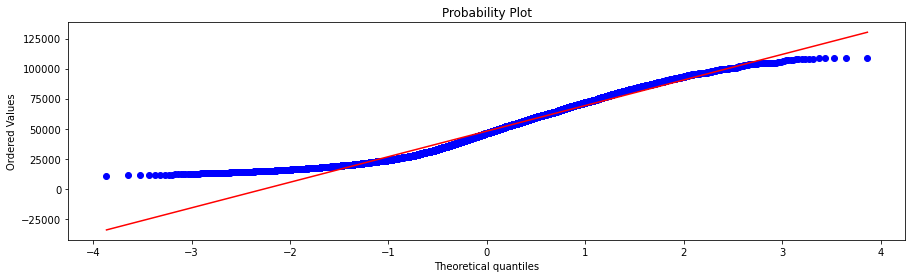

In [ ]:
# plotting the quarterly sales price
plot_data(df_quart, 'quarterly_sales')

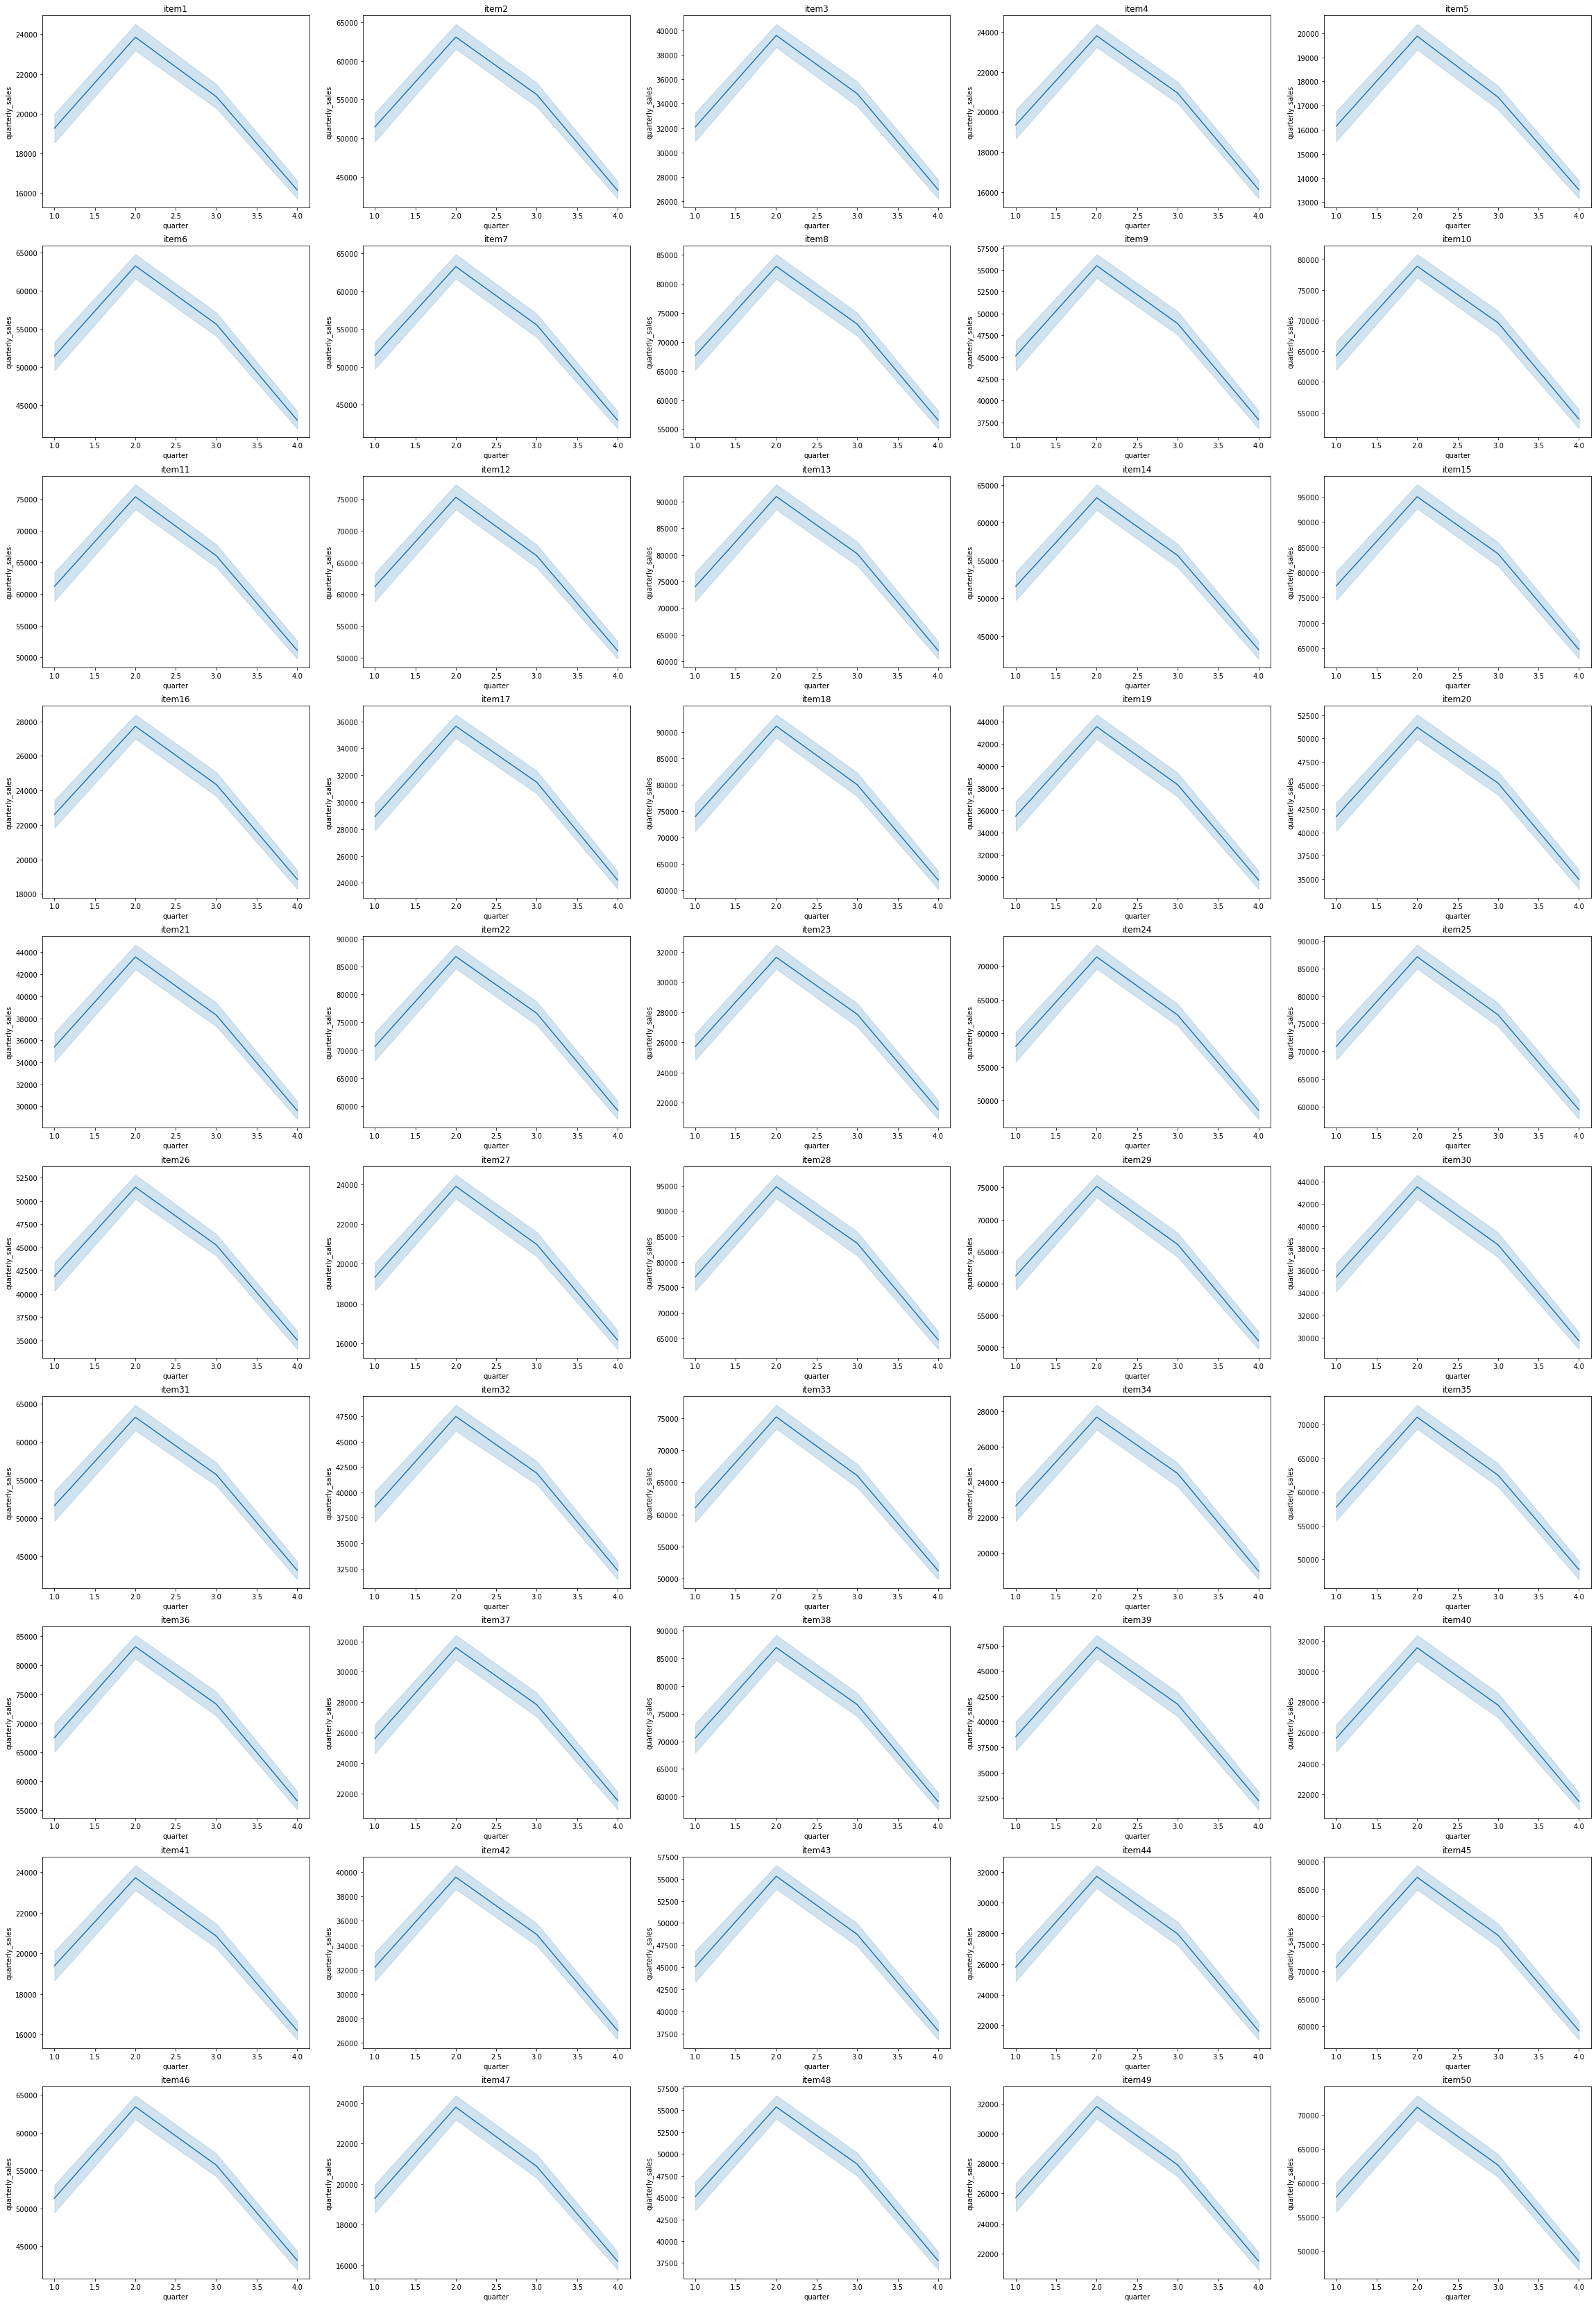

In [ ]:
# plotting the each and every item based on quarterly sales
fig, axes = plt.subplots(10, 5, figsize = (40,60))

for i in range(50):
  sns.lineplot(ax = axes[int(i/5),i%5], data = df_quart[df_quart['item'] == i+1 ], x = 'quarter', y = 'quarterly_sales')
  axes[int(i/5),i%5].set_title('item' + str(i+1))

In [ ]:
df_quart.shape

(12450, 7)

In [ ]:
df_quart.head()

,item,date,quarterly_sales,year,day,quarter,month
0,1,2013-01-01,12981,2013,1,1,1
1,1,2013-01-08,13542,2013,8,1,1
2,1,2013-01-15,14030,2013,15,1,1
3,1,2013-01-22,14500,2013,22,1,1
4,1,2013-01-29,15003,2013,29,1,1


In [ ]:
# One-Hot Encoding

df = pd.get_dummies(df_quart, columns=['item'])

df.shape

(12450, 56)

In [ ]:
df.head()

,date,quarterly_sales,year,day,quarter,month,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
0,2013-01-01,12981,2013,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2013-01-08,13542,2013,8,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2013-01-15,14030,2013,15,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2013-01-22,14500,2013,22,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2013-01-29,15003,2013,29,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_quart_new = df_quart.copy()
df_quart_new = pd.get_dummies(df_quart['item'])


# we cannot perform slicing on numerical column names. pandas doesn't allow as to do that
# pandas provide inbuild function called add_prefix to convert column nmaes to objects
df_quart_new = df_quart_new.add_prefix('item_')


df_model = pd.concat([df_quart, df_quart_new], axis=1)
df_model.head()

,item,date,quarterly_sales,year,day,quarter,month,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
0,1,2013-01-01,12981,2013,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2013-01-08,13542,2013,8,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,2013-01-15,14030,2013,15,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,2013-01-22,14500,2013,22,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,2013-01-29,15003,2013,29,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Dropping the unwanted features like dates and item
df_model.drop(['date', 'item'], axis=1, inplace=True)

In [ ]:
df_model.head()

,quarterly_sales,year,day,quarter,month,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
0,12981,2013,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,13542,2013,8,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,14030,2013,15,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14500,2013,22,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,15003,2013,29,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Checking the datatypes of the final dataframe
df_model.dtypes

quarterly_sales    int64
year               int64
day                int64
quarter            int64
month              int64
item_1             uint8
item_2             uint8
item_3             uint8
item_4             uint8
item_5             uint8
item_6             uint8
item_7             uint8
item_8             uint8
item_9             uint8
item_10            uint8
item_11            uint8
item_12            uint8
item_13            uint8
item_14            uint8
item_15            uint8
item_16            uint8
item_17            uint8
item_18            uint8
item_19            uint8
item_20            uint8
item_21            uint8
item_22            uint8
item_23            uint8
item_24            uint8
item_25            uint8
item_26            uint8
item_27            uint8
item_28            uint8
item_29            uint8
item_30            uint8
item_31            uint8
item_32            uint8
item_33            uint8
item_34            uint8
item_35            uint8


In [ ]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12450 entries, 0 to 12449
Data columns (total 55 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   quarterly_sales  12450 non-null  int64
 1   year             12450 non-null  int64
 2   day              12450 non-null  int64
 3   quarter          12450 non-null  int64
 4   month            12450 non-null  int64
 5   item_1           12450 non-null  uint8
 6   item_2           12450 non-null  uint8
 7   item_3           12450 non-null  uint8
 8   item_4           12450 non-null  uint8
 9   item_5           12450 non-null  uint8
 10  item_6           12450 non-null  uint8
 11  item_7           12450 non-null  uint8
 12  item_8           12450 non-null  uint8
 13  item_9           12450 non-null  uint8
 14  item_10          12450 non-null  uint8
 15  item_11          12450 non-null  uint8
 16  item_12          12450 non-null  uint8
 17  item_13          12450 non-null  uint8
 18  item_1

In [ ]:
# segregate  the dataframe into train ,validate and test based on year column
train_df = df_model.loc[(df_model["year"] <=2015)]
val_df = df_model.loc[(df_model["year"] == 2016), :]
test_df = df_model.loc[(df_model["year"] == 2017)]

In [ ]:
# spliting the data into x_train and y_train like that 
X_train = train_df.drop(columns = ['quarterly_sales'])
Y_train = train_df['quarterly_sales']

val_train = val_df.drop(columns = ['quarterly_sales'])
val_test = val_df['quarterly_sales']

x_test = test_df.drop(columns = ['quarterly_sales'])
y_test = test_df['quarterly_sales']


In [ ]:
# checking the shape of the train and test data
print('shape of X_train : {}'.format(X_train.shape))
print('shape of Y_train : {}'.format(Y_train.shape))
print()
print('shape of val_train : {}'.format(val_train.shape))
print('shape of val_test : {}'.format(val_test.shape))
print()
print('shape of X_test : {}'.format(x_test.shape))
print('shape of y_test : {}'.format(y_test.shape))

shape of X_train : (7850, 54)
shape of Y_train : (7850,)

shape of val_train : (2600, 54)
shape of val_test : (2600,)

shape of X_test : (2000, 54)
shape of y_test : (2000,)


# LIGHTGBM MODEL

In [ ]:
#hyper parameters for lightGBM
lgbm_params ={ "num_leaves": [10,15,25,35],
              "learning_rate": [0.1, 0.05, 0.02],
              "colsample_bytree":[0.5, 0.8, 1.0],
              "max_depth": [5, 9, 15, 25],
             }

In [ ]:
# fitting the model
model = lgb.LGBMRegressor()
tscv = TimeSeriesSplit(n_splits=3)
rsearch2 = RandomizedSearchCV(model, lgbm_params, cv=tscv, verbose = True, n_jobs = -1).fit( X_train, Y_train ) 

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
# Best Parameters
rsearch2.best_params_

{'num_leaves': 35,
 'max_depth': 25,
 'learning_rate': 0.02,
 'colsample_bytree': 1.0}

In [ ]:
# Using the above best parameters of randomized search cv we can give to lightGBM model
parameters = {'metric': 'root_mean_squared_error',
              'boosting': 'gbdt',
              'num_leaves': 35,
              'feature_fraction': 0.5,
              'bagging_fraction': 0.5,
              'bagging_freq': 20,
              'max_depth': 25,
              'learning_rate': 0.02,
              'verbose': -1,
              'colsample_bytree':1.0
             }

In [ ]:
# loading the dataset into model for training
lgbtrain = lgb.Dataset(data=X_train, label=Y_train)


In [ ]:
# loading the validation dataset
lgbval = lgb.Dataset(data=val_train, label=val_test)

In [ ]:
# training the model with train and validation dataset with parameter
# using the number of bossting rounds 1000 and stop at maximum 50% more in  early stopping round
model = lgb.train(parameters,
                        lgbtrain,
                        valid_sets=lgbval,
                        num_boost_round=2000,
                        early_stopping_rounds=50)

[1]	valid_0's rmse: 23616.8
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 23487.1
[3]	valid_0's rmse: 23307.8
[4]	valid_0's rmse: 23114.6
[5]	valid_0's rmse: 22930.4
[6]	valid_0's rmse: 22789.1
[7]	valid_0's rmse: 22639.4
[8]	valid_0's rmse: 22460.1
[9]	valid_0's rmse: 22304.4
[10]	valid_0's rmse: 22134.4
[11]	valid_0's rmse: 21957.7
[12]	valid_0's rmse: 21806.3
[13]	valid_0's rmse: 21648.9
[14]	valid_0's rmse: 21481.2
[15]	valid_0's rmse: 21332
[16]	valid_0's rmse: 21192.9
[17]	valid_0's rmse: 21024.4
[18]	valid_0's rmse: 20874.6
[19]	valid_0's rmse: 20750.5
[20]	valid_0's rmse: 20576.6
[21]	valid_0's rmse: 20427.7
[22]	valid_0's rmse: 20272.6
[23]	valid_0's rmse: 20140.6
[24]	valid_0's rmse: 20014.9
[25]	valid_0's rmse: 19888.2
[26]	valid_0's rmse: 19747.5
[27]	valid_0's rmse: 19614.9
[28]	valid_0's rmse: 19479.8
[29]	valid_0's rmse: 19333
[30]	valid_0's rmse: 19185
[31]	valid_0's rmse: 19057.3
[32]	valid_0's rmse: 18921.3
[33]	valid_0's rmse: 18794

[310]	valid_0's rmse: 5753.98
[311]	valid_0's rmse: 5742.63
[312]	valid_0's rmse: 5728.78
[313]	valid_0's rmse: 5716.5
[314]	valid_0's rmse: 5704.26
[315]	valid_0's rmse: 5696.54
[316]	valid_0's rmse: 5686.35
[317]	valid_0's rmse: 5675.61
[318]	valid_0's rmse: 5670.2
[319]	valid_0's rmse: 5663.93
[320]	valid_0's rmse: 5657.42
[321]	valid_0's rmse: 5651.04
[322]	valid_0's rmse: 5642.82
[323]	valid_0's rmse: 5636.47
[324]	valid_0's rmse: 5626.29
[325]	valid_0's rmse: 5620.45
[326]	valid_0's rmse: 5613.49
[327]	valid_0's rmse: 5607.12
[328]	valid_0's rmse: 5601.15
[329]	valid_0's rmse: 5594.19
[330]	valid_0's rmse: 5584.37
[331]	valid_0's rmse: 5577.95
[332]	valid_0's rmse: 5568.57
[333]	valid_0's rmse: 5559.48
[334]	valid_0's rmse: 5551.23
[335]	valid_0's rmse: 5542.69
[336]	valid_0's rmse: 5536.72
[337]	valid_0's rmse: 5528.32
[338]	valid_0's rmse: 5522.76
[339]	valid_0's rmse: 5511.87
[340]	valid_0's rmse: 5503.76
[341]	valid_0's rmse: 5493.47
[342]	valid_0's rmse: 5488.85
[343]	valid_

[631]	valid_0's rmse: 4674.72
[632]	valid_0's rmse: 4673.74
[633]	valid_0's rmse: 4672.52
[634]	valid_0's rmse: 4671.41
[635]	valid_0's rmse: 4670.35
[636]	valid_0's rmse: 4670.3
[637]	valid_0's rmse: 4669.77
[638]	valid_0's rmse: 4669.16
[639]	valid_0's rmse: 4668.75
[640]	valid_0's rmse: 4668.38
[641]	valid_0's rmse: 4668.11
[642]	valid_0's rmse: 4666.19
[643]	valid_0's rmse: 4665.94
[644]	valid_0's rmse: 4664.06
[645]	valid_0's rmse: 4663.38
[646]	valid_0's rmse: 4663.43
[647]	valid_0's rmse: 4661.61
[648]	valid_0's rmse: 4660.88
[649]	valid_0's rmse: 4660.65
[650]	valid_0's rmse: 4658.64
[651]	valid_0's rmse: 4656.71
[652]	valid_0's rmse: 4656.33
[653]	valid_0's rmse: 4654.5
[654]	valid_0's rmse: 4654.19
[655]	valid_0's rmse: 4653.87
[656]	valid_0's rmse: 4653.55
[657]	valid_0's rmse: 4652.12
[658]	valid_0's rmse: 4650.8
[659]	valid_0's rmse: 4650.51
[660]	valid_0's rmse: 4648.98
[661]	valid_0's rmse: 4648.61
[662]	valid_0's rmse: 4647.88
[663]	valid_0's rmse: 4647.69
[664]	valid_0

[968]	valid_0's rmse: 4541.91
[969]	valid_0's rmse: 4542.11
[970]	valid_0's rmse: 4542.11
[971]	valid_0's rmse: 4541.91
[972]	valid_0's rmse: 4542.2
[973]	valid_0's rmse: 4542.16
[974]	valid_0's rmse: 4542.27
[975]	valid_0's rmse: 4542.18
[976]	valid_0's rmse: 4542.31
[977]	valid_0's rmse: 4542.49
[978]	valid_0's rmse: 4542.41
[979]	valid_0's rmse: 4542.66
[980]	valid_0's rmse: 4542.74
[981]	valid_0's rmse: 4543.02
[982]	valid_0's rmse: 4543.37
[983]	valid_0's rmse: 4542.77
[984]	valid_0's rmse: 4543.08
[985]	valid_0's rmse: 4543.32
[986]	valid_0's rmse: 4543.18
[987]	valid_0's rmse: 4543.03
[988]	valid_0's rmse: 4543.32
[989]	valid_0's rmse: 4543.38
[990]	valid_0's rmse: 4543.52
[991]	valid_0's rmse: 4543.38
[992]	valid_0's rmse: 4543.44
[993]	valid_0's rmse: 4543.15
[994]	valid_0's rmse: 4543.08
[995]	valid_0's rmse: 4543.33
[996]	valid_0's rmse: 4543.46
[997]	valid_0's rmse: 4543.58
[998]	valid_0's rmse: 4543.31
[999]	valid_0's rmse: 4543.49
[1000]	valid_0's rmse: 4543.31
[1001]	val

[1254]	valid_0's rmse: 4511.24
[1255]	valid_0's rmse: 4510.95
[1256]	valid_0's rmse: 4511.18
[1257]	valid_0's rmse: 4511.3
[1258]	valid_0's rmse: 4511.81
[1259]	valid_0's rmse: 4511.99
[1260]	valid_0's rmse: 4512.31
[1261]	valid_0's rmse: 4511.27
[1262]	valid_0's rmse: 4510.75
[1263]	valid_0's rmse: 4510.47
[1264]	valid_0's rmse: 4510.19
[1265]	valid_0's rmse: 4510.24
[1266]	valid_0's rmse: 4510.06
[1267]	valid_0's rmse: 4509.06
[1268]	valid_0's rmse: 4509.05
[1269]	valid_0's rmse: 4507.99
[1270]	valid_0's rmse: 4506.99
[1271]	valid_0's rmse: 4506.06
[1272]	valid_0's rmse: 4505.53
[1273]	valid_0's rmse: 4504.48
[1274]	valid_0's rmse: 4503.69
[1275]	valid_0's rmse: 4503.09
[1276]	valid_0's rmse: 4502.37
[1277]	valid_0's rmse: 4502.38
[1278]	valid_0's rmse: 4501.58
[1279]	valid_0's rmse: 4501.38
[1280]	valid_0's rmse: 4500.66
[1281]	valid_0's rmse: 4500.9
[1282]	valid_0's rmse: 4500.7
[1283]	valid_0's rmse: 4500.88
[1284]	valid_0's rmse: 4501.14
[1285]	valid_0's rmse: 4501.08
[1286]	vali

In [ ]:
# predicting the values for training and validtion
y_train_pred = model.predict(X_train) 
y_valid_pred = model.predict(val_train)

In [ ]:
# printing the accuacy using the r2_score 
print("r2_score Train: {:.4f}\nr2_score Valid: {:.4f}".format(r2_score(Y_train, y_train_pred),
                                                    r2_score(val_test, y_valid_pred)))

r2_score Train: 0.9986
r2_score Valid: 0.9608


# R2 Score Train: 0.9986
# R2 Score Valid: 0.9608

# FEATURE IMPORTANCE

Text(0, 0.5, 'Feature Importance Score')

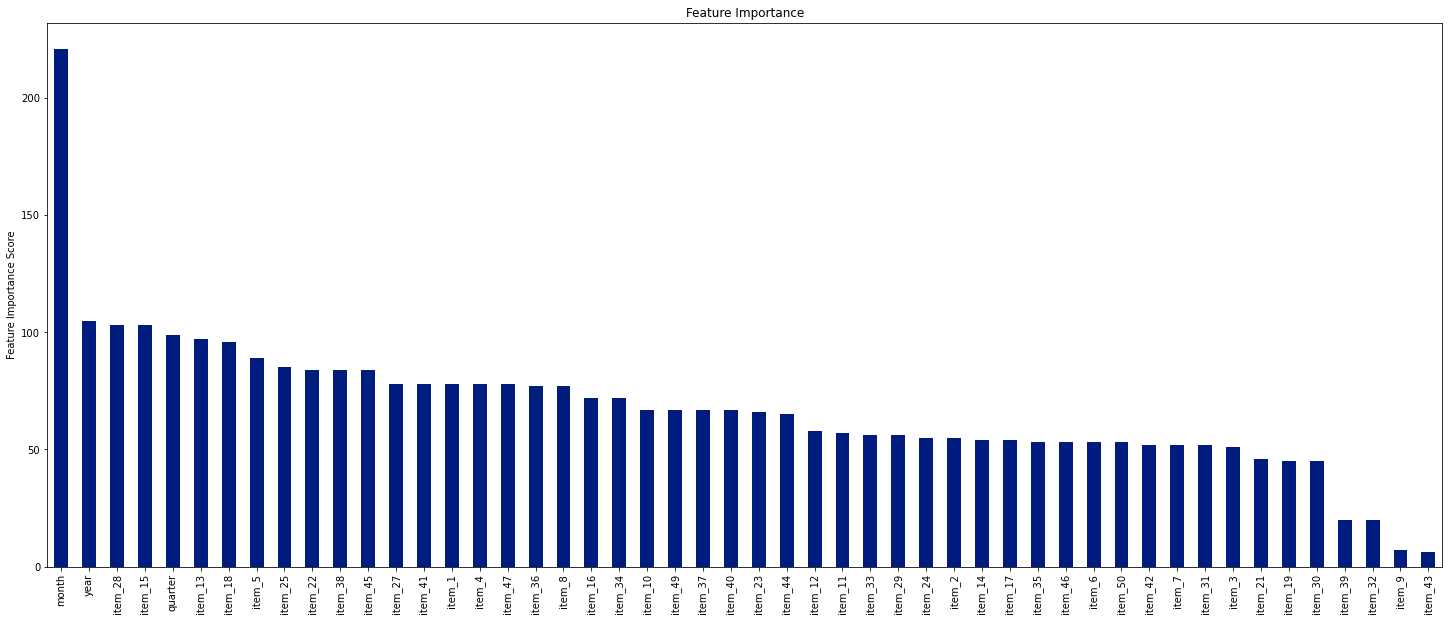

In [ ]:
# mapping the feature importance
predictors = [x for x in X_train.columns]
feat_imp = pd.Series(rsearch2.best_estimator_.feature_importances_, predictors).sort_values(ascending=False)
feat_imp = feat_imp[0:50]
plt.rcParams['figure.figsize'] = 25, 10
feat_imp.plot(kind='bar', title='Feature Importance')
plt.ylabel('Feature Importance Score')

# FINAL MODEL

In [ ]:
#predicting for the test data 
predict = model.predict(x_test)

In [ ]:
predict

array([14216.34397898, 15828.20445266, 16868.50793919, ...,
       58516.59605488, 57912.36711618, 54232.46877967])

In [ ]:
r2_score(y_test, predict)

0.9132131533546006

# R2 Score= 0.9132131533546006

In [ ]:
df_final = test_df

In [ ]:
df_final.head()

,quarterly_sales,year,day,quarter,month,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,predict
209,17715,2017,3,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14114
210,18366,2017,10,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15543
211,18990,2017,17,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16335
212,19656,2017,24,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17534
213,20344,2017,31,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18792


In [ ]:
df_final.shape

(2000, 56)

In [ ]:
p = predict.astype(int) 
 
# appending the values to dataframe
df_final['predict'] = p 

In [ ]:
df_final

,quarterly_sales,year,day,quarter,month,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,predict
209,17715,2017,3,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14216
210,18366,2017,10,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15828
211,18990,2017,17,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16868
212,19656,2017,24,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17861
213,20344,2017,31,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12445,68007,2017,5,3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,60262
12446,66445,2017,12,3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,59546
12447,64902,2017,19,3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,58516
12448,63360,2017,26,3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,57912


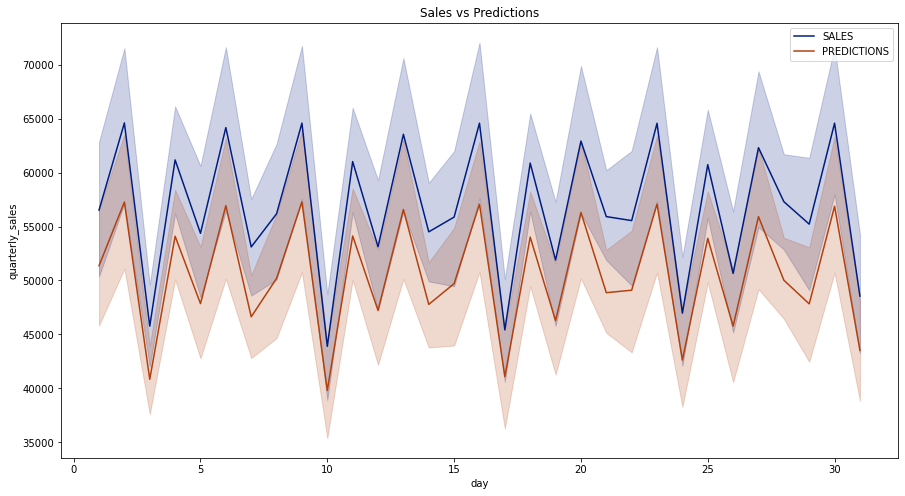

In [ ]:
plt.figure(figsize=(15, 8))
plt.title("Sales vs Predictions")
sns.set_palette("dark")


sns.lineplot( x='day', y='quarterly_sales', data=df_final,palette="RdPu",label='SALES' )
sns.lineplot( x='day', y='predict', data=df_final,palette="RdPu", label='PREDICTIONS' )

plt.show()